#### LangGraph에서 도구(tool) 활용 방법

- 도구(tool)를 활용한 에이전트 개발 방법을 알아봅니다
- workflow를 직접 선언하지 않고, 사용가능한 도구들을 전달하면, 에이전트가 적합한 도구를 판단해서 사용합니다
    - 이번 회차에서는 `ToolNode`를 통해 도구를 활용하는 방법을 알아봅니다

In [1]:
from dotenv import load_dotenv
import os
# .env 파일을 불러와서 환경 변수로 설정
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
Fy


In [2]:
# from langchain_upstage import ChatUpstage
# llm = ChatUpstage(
#         model="solar-pro",
#         base_url="https://api.upstage.ai/v1",
#         temperature=0.5
#     )
# print(llm)

from langchain_openai import ChatOpenAI
llm=ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=0
    )


c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

- LangGraph는 `ToolNode`를 통해 도구를 활용합니다
- `ToolNode`의 `invoke()`결과는 도구의 `invoke()` 결과와 유사합니다
    - 도구는 도구의 실행 결과를 리턴하고, `ToolNode`는 도구의 실행 결과를 포함한 `ToolMessage`를 리턴합니다

In [4]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

print(type(llm_with_tools))
print(tool_node)

<class 'langchain_core.runnables.base.RunnableBinding'>
tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'add': StructuredTool(name='add', description='숫자 a와 b를 더합니다.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000017F07FD6020>), 'multiply': StructuredTool(name='multiply', description='숫자 a와 b를 곱합니다.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000017F07FD51C0>)}, tool_to_state_args={'add': {}, 'multiply': {}}, tool_to_store_arg={'add': None, 'multiply': None}, handle_tool_errors=True, messages_key='messages')


In [5]:
result = multiply.invoke({'a': 3, 'b': 5})
print(type(result))

<class 'int'>


In [6]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yVdIsw0YWLmnv729LPbfyvTl', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 88, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CJqdQm2XcswvOy5PT1ZpSeWkJ6rW0', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3d54f88b-115e-4394-8081-54452635d9e0-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_yVdIsw0YWLmnv729LPbfyvTl', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 17, 'total_tokens': 105, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_to

In [7]:
ai_message.tool_calls

[{'name': 'add',
  'args': {'a': 3, 'b': 5},
  'id': 'call_yVdIsw0YWLmnv729LPbfyvTl',
  'type': 'tool_call'}]

- `ToolNode`를 `invoke()`하려면 `tool_calls` 속성을 포함한 `AIMessage`를 전달해야 합니다

In [8]:
tool_msg = tool_node.invoke({'messages': [ai_message]})

print(type(tool_msg))
print(tool_msg)

<class 'dict'>
{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_yVdIsw0YWLmnv729LPbfyvTl')]}


- 간단한 에이전트를 만들기 위해 LangGraph에서 제공하는 [`StateGraph`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)를 사용합니다

In [9]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    
    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

In [ ]:
def tool_agent((state: MessagesState)-> MessagesState):
    pass

In [12]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정합니다.

    Args:
        state (MessagesState): `state`를 포함하는 객체.

    Returns:
        Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고, 
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    print(messages)
    
    # 마지막 AI 메시지를 가져옵니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
    return END

- `node`를 추가하고 `edge`로 연결합니다

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

graph_builder.edges

{('__start__', 'agent'), ('tools', 'agent')}

<class 'langgraph.graph.state.CompiledStateGraph'>


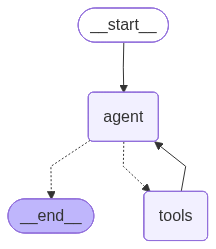

In [16]:
graph= graph_builder.compile()
print(type(graph))

graph

In [ ]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.


- `graph.stream()`을 활용하면 에이전트가 답변을 생성하는 과정을 모니터링 할 수 있습니다

In [17]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
[HumanMessage(content='3에다 5를 더하고 거기에 8을 곱하면?', additional_kwargs={}, response_metadata={}, id='6b2a1e76-9758-4eee-a9e5-aaf396d0b148'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2oh686ehmfcQdE6HoL25MvOd', 'function': {'arguments': '{"a": 3, "b": 5}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_FgLOAXExk97EV3w2QJgRdGRy', 'function': {'arguments': '{"a": 8, "b": 8}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 103, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CJr72ThjsKcapHU9XtMmxwYaNekd2', 'service_tie

#### LangGraph 내장 ReAct 에이전트 사용
* create_react_agent()의 작동 방식
    * create_react_agent()는 함수 내부에서 이미 StateGraph와 필요한 노드(사고,도구실행,응담)를 자동으로 구성 

In [ ]:
from langgraph.prebuilt import create_react_agent
from langchain.agents import tool

from langchain_core.messages import HumanMessage
from langchain_upstage import ChatUpstage

# llm = ChatUpstage(
#         model="solar-pro",
#         base_url="https://api.upstage.ai/v1",
#         temperature=0.5
#     )
# print(llm)

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model='gpt-3.5-turbo-0125', 
    temperature=0,
)
print(llm.model_name)

@tool
def add2(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

# 한 줄로 에이전트 생성 - 내부에서 StateGraph를 자동 구성

agent = create_react_agent(model=llm, tools=[add2])
print(type(agent))

# 바로 사용 가능
result = agent.invoke({"messages": [HumanMessage(content="3+5는?")]})

print(result)

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


client=<openai.resources.chat.completions.completions.Completions object at 0x00000187A5A76960> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000187A5B8C2C0> model_name='solar-pro' temperature=0.5 model_kwargs={} upstage_api_key=SecretStr('**********') upstage_api_base='https://api.upstage.ai/v1'
solar-pro
<class 'langgraph.graph.state.CompiledStateGraph'>
{'messages': [HumanMessage(content='3+5는?', additional_kwargs={}, response_metadata={}, id='86d81d1a-e34e-420e-9e13-31e6f1aafb22'), AIMessage(content='8  \n\nThe question "3+5는?" (what is 3+5?) can be answered directly using general arithmetic knowledge without requiring any function calls. The sum of 3 and 5 is 8.  \n\nNo function calls are needed as this is basic mathematical knowledge.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 509, 'total_tokens': 569, 'completion_tokens_details': {'accepted_prediction_tokens': 0,

In [4]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain.agents import tool
from langchain_core.messages import HumanMessage

# 더 복잡한 도구들 정의
@tool
def calculate_compound_interest(principal: float, rate: float, years: int) -> str:
    """원금, 이자율, 기간을 받아 복리 이자를 계산합니다."""
    amount = principal * (1 + rate/100) ** years
    interest = amount - principal
    return f"{years}년 후 원리금: {amount:,.0f}원, 이자: {interest:,.0f}원"

@tool
def calculate_tax(income: float) -> str:
    """연소득을 받아 간이 세액을 계산합니다."""
    if income <= 12000000:
        tax = income * 0.06
    elif income <= 46000000:
        tax = 720000 + (income - 12000000) * 0.15
    elif income <= 88000000:
        tax = 5820000 + (income - 46000000) * 0.24
    else:
        tax = 15900000 + (income - 88000000) * 0.35
    
    return f"예상 세액: {tax:,.0f}원, 세후 소득: {income - tax:,.0f}원"

@tool
def get_weekday(date_str: str) -> str:
    """YYYY-MM-DD 형식의 날짜를 받아 요일을 반환합니다."""
    from datetime import datetime
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
    weekdays = ["월요일", "화요일", "수요일", "목요일", "금요일", "토요일", "일요일"]
    return f"{date_str}은 {weekdays[date_obj.weekday()]}입니다."

# LLM 초기화
llm = ChatOpenAI(model="gpt-3.5-turbo")
print(llm.model_name)

# 도구 리스트
tools_list = [calculate_compound_interest, calculate_tax, get_weekday]

# ReAct 에이전트 생성
agent = create_react_agent(model = llm, tools=tools_list)

gpt-3.5-turbo


In [ ]:
# 복합적인 질문 테스트
complex_questions = [
    "1억원을 연 5% 복리로 10년 동안 예금하면 얼마가 될까?",
    "연소득 5천만원일 때 내야 할 세금은 얼마야?",
    "2024-12-25은 무슨 요일이야?",
    "연소득 8천만원일 때 세금을 계산하고, 남은 돈을 연 4% 복리로 5년간 예금하면 얼마가 돼?"
]

for question in complex_questions:
    print(f"\n질문: {question}")
    print("-" * 50)
    
    result = agent.invoke({"messages": [HumanMessage(content=question)]})
    response = result["messages"][-1].content
    
    print(f"답변: {response}")
    print("=" * 80)

In [5]:
for question in complex_questions:
    for chunk in agent.stream({'messages': [HumanMessage(content=question)]}, stream_mode='values'):
        chunk['messages'][-1].pretty_print()

================================ Human Message =================================

1억원을 연 5% 복리로 10년 동안 예금하면 얼마가 될까?
================================== Ai Message ==================================
Tool Calls:
  calculate_compound_interest (call_Ls2TEUueD9vyyFG6GqET6THE)
 Call ID: call_Ls2TEUueD9vyyFG6GqET6THE
  Args:
    principal: 100000000
    rate: 0.05
    years: 10
================================= Tool Message =================================
Name: calculate_compound_interest

10년 후 원리금: 100,501,127원, 이자: 501,127원
================================== Ai Message ==================================

1억원을 연 5% 복리로 10년 동안 예금하면 10년 후에는 약 1억 5012만 7천원이 될 것입니다.
================================ Human Message =================================

연소득 5천만원일 때 내야 할 세금은 얼마야?
================================== Ai Message ==================================
Tool Calls:
  calculate_tax (call_F9JgtlDF1uvNQ0KXlS2DROih)
 Call ID: call_F9JgtlDF1uvNQ0KXlS2DROih
  Args:
    income: 50000000
===============